# Structure functions for multiple snapshots or observations with bootstrapping

This example will guide you through calculating structure functions for multiple snapshots of a 2D simulation of surface ocean velocity. 

**General procedure:**

1. Load a dataset generated with GeophysicalFlows.jl
2. Format the dataset
3. For each snapshot, calculate velocity-based structure functions for the zonal and meridional directions as a function of separation distance
4. Use scipy's bootstrapping method to estimate the mean structure functions and generate confidence intervals
5. Plot the mean structure functions and shade the confidence intervals

In [1]:
import matplotlib_inline.backend_inline
import seaborn as sns

sns.set_style(style="white")
sns.set_context("talk")

matplotlib_inline.backend_inline.set_matplotlib_formats("png", dpi=200)

### Load the dataset generated with GeophysicalFlows.jl
We will use `h5py` to load a `.jld2` file, the output from `GeophysicalFlows.jl`, a numerical ocean simulator written in Julia.

In [2]:
import h5py
   
f = h5py.File('example_data/2layer_128.jld2', 'r')
grid = f['grid']
snapshots = f['snapshots']

# Initialize the grid of x and y coordinates
x = grid['x'][()]
y = grid['y'][()]

# Grab u, v, and q for all snapshots and layers (we will just use the top layer)
u = snapshots['u']
v = snapshots['v']
q = snapshots['q']

### Calculate advective velocity structure functions for all snapshots

Here we use list comprehension to iterate through the snapshots in the dataset and generate structure functions for each snapshot. `[0]` ensures that we are selecting the top layer in this dataset since `u` and `v` have shape `[2, 128, 128]`.

In [3]:
import fluidsf

sfs_list = [
    fluidsf.generate_structure_functions(u[d][0], v[d][0], x, y) 
    for d in u.keys()]

### Bootstrap to generate a mean structure function and confidence intervals

We are using [scipy's bootstrapping method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html) here, though other methods of estimating error and variability are possible. We will use a confidence level of 90%.

In [4]:
import warnings

import numpy as np
from scipy.stats import bootstrap

warnings.filterwarnings("ignore") # Ignore warnings for the purpose of this tutorial

# Reformat single sfs_list for ease of boostrapping
sf_x = []
sf_y = []

for sf in sfs_list:
    sf_x.append(sf["SF_advection_velocity_x"])
    sf_y.append(sf["SF_advection_velocity_y"])

# Bootstrap the zonal and meridional structure functions with 90% confidence levels
boot_sf_vx = bootstrap((sf_x,), np.mean, confidence_level=0.9, axis=0)
boot_sf_vy = bootstrap((sf_y,), np.mean, confidence_level=0.9, axis=0)

# Generate the confidence intervals for both sets of structure functions, still at 90%
boot_sf_vx_conf = boot_sf_vx.confidence_interval
boot_sf_vy_conf = boot_sf_vy.confidence_interval

# Compute the mean -- this can also be accomplished with a Python mean function 
# and will return the same result
boot_sf_vx_mean = boot_sf_vx.bootstrap_distribution.mean(axis=1)
boot_sf_vy_mean = boot_sf_vy.bootstrap_distribution.mean(axis=1)

### Plot mean structure functions and confidence intervals

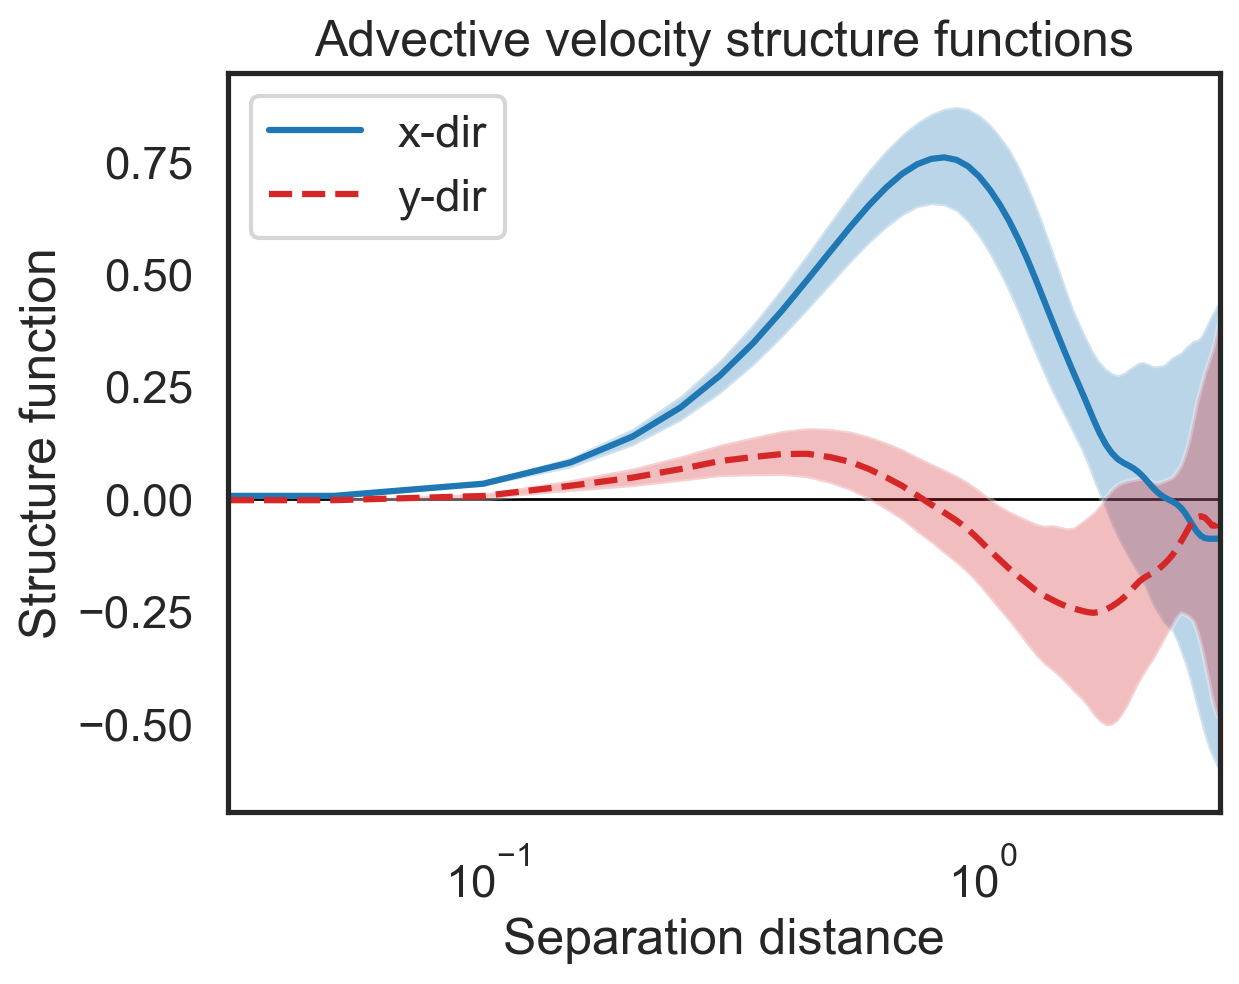

In [5]:
import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots()

ax1.semilogx(sfs_list[0]['x-diffs'], boot_sf_vx_mean,label=r'x-dir',color='tab:blue')
ax1.semilogx(sfs_list[0]['y-diffs'], boot_sf_vy_mean, label=r'y-dir', 
             color='tab:red', linestyle='dashed')

# Shade in the confidence regions
ax1.fill_between(sfs_list[0]['x-diffs'],boot_sf_vx_conf[0],
                 boot_sf_vx_conf[1],color='tab:blue',alpha=0.3,edgecolor=None)
ax1.fill_between(sfs_list[0]['y-diffs'],boot_sf_vy_conf[0],
                 boot_sf_vy_conf[1],color='tab:red',alpha=0.3,edgecolor=None)

ax1.set_ylabel(r"Structure function")
ax1.set_xlabel(r"Separation distance")
ax1.set_xlim(3e-2,3e0)
ax1.legend()
plt.hlines(0,3e-2,3e0,color='k',lw=1,zorder=0)
plt.title('Advective velocity structure functions');

This same process can be repeated for the other types of structure functions as described in the previous example.